## Saliency maps using backpropagation

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Reshape,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,..,3
y_train = y_train[y_train <= 3]
x_train = np.expand_dims(x_train,axis=-1)
x_train,y_train = x_train[:24600],y_train[:24600]
x_train = np.reshape(x_train,(24600,-1))
x_train.shape,y_train.shape

((24600, 784), (24600,))

In [3]:
x_train = x_train/255 # scaling the images

In [4]:
def get_model():
    """ Simple feed-forward model
    """
    x = Input(shape=(784))
    h1 = Dense(100,activation='relu')(x)
    h2 = Dense(50,activation='relu')(h1)
    o = Dense(4,activation=None)(h2)
    
    model = Model(inputs=x,outputs=o)
    return model

In [5]:
@tf.function
def train(model,optimizer,x_train_subset,y_train_subset):
    with tf.GradientTape() as tape:
        o = model(x_train_subset)
        loss = SparseCategoricalCrossentropy(from_logits=True)(y_train_subset,o)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [6]:
model = get_model()

In [7]:
batch_size=50
epochs=5
optimizer = Adam(lr=0.01)

for epoch_i in range(epochs):
    losses = []
    for i in range(0,len(x_train),batch_size):
        x_train_subset = x_train[i:i+batch_size]
        y_train_subset = y_train[i:i+batch_size]
        batch_loss = train(model,optimizer,x_train_subset,y_train_subset)
        losses.append(float(batch_loss))
        
    print("Epoch {}: {}".format(epoch_i+1,round(sum(losses)/len(losses),6)))

Epoch 1: 0.100432
Epoch 2: 0.055741
Epoch 3: 0.047627
Epoch 4: 0.032283
Epoch 5: 0.023064


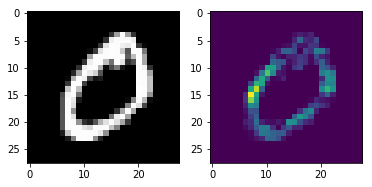

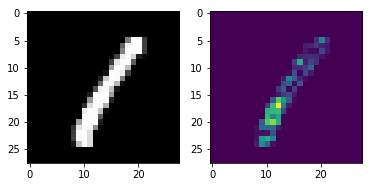

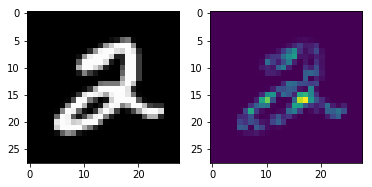

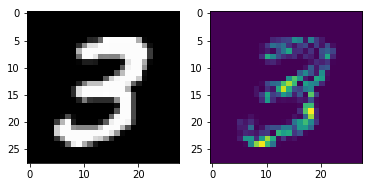

In [8]:
for x_i in [0,1,2,4]:
    x_ = np.expand_dims(x_train[x_i],axis=0)
    x_ = tf.Variable(x_,trainable=True)
    with tf.GradientTape() as tape:
        tape.watch(x_)
        o = model(x_)
    gradients = tape.gradient(o,x_).numpy()
    
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(x_train[x_i],(28,28)),cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(x_train[x_i]*np.abs(gradients),(28,28)))
    plt.show()